In [326]:
import math
import numpy as np
import scipy.integrate as integrate   # для решения ОДУ в методе DEM
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12) 

# Hashin–Shtrikman bounds (HS)

In [327]:
# HS - bulk модуль - 2 компоненты (prop - в процентах)
def get_HS_bulk_bounds(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для объемного модуля сжатия (bulk) композита,
    # состоящего из двух компонент

    # входные данные
    k1, k2 = bulk        # объемные модули сжатия (bulk) 1ой и 2ой компонент
    g1, g2 = shear       # модули сдвига (shear) 1ой и 2ой компонент
    f1 = prop / 100       # объмное содержание 1ой компоненты (f1 - в долях, prop - в %)
    f2 = 1 - prop / 100   # объемное содержание 2ой компоненты
    
    # случай 1
    if k1 == k2:
        return k

    # случай 2: (k1 > k2) and (g1 > g2) - компонента 1 более жесткая
    if ((k1 - k2) * (g1 - g2) > 0) or (g1 == g2):
        bulk_bounds = sorted([k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))])
    else:
        # случай 3.1: (k1 > k2) but (g1 < g2)
        if k1 > k2:
            if k1 + 0.5 / (1 / (k2 - k1) + 0.5 / (k1 + 4 * g1 / 3)) > k2 + 0.5 / (
                    1 / (k1 - k2) + 0.5 / (k2 + 4 * g2 / 3)):
                bulk_bounds = [k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3)),
                               k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3))]
            else:
                bulk_bounds = [k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))]
        # случай 3.2: (k1 < k2) but (g1 > g2)
        else:
            if k1 + 0.5 / (1 / (k2 - k1) + 0.5 / (k1 + 4 * g1 / 3)) > k2 + 0.5 / (
                    1 / (k1 - k2) + 0.5 / (k2 + 4 * g2 / 3)):
                bulk_bounds = [k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3)),
                               k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3))]
            else:
                bulk_bounds = [k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))]

    return bulk_bounds



# HS - shear модуль - 2 компоненты (prop - в процентах)
def get_HS_shear_bounds(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для модуля сдвига (shear) композита,
    # состоящего из двух компонент

    # входные данные
    k1, k2 = bulk  # объемные модули сжатия (bulk) 1ой и 2ой компонент
    g1, g2 = shear  # модули сдвига (shear) 1ой и 2ой компонент
    f1 = prop / 100  # объмное содержание 1ой компоненты (f1 - в долях, prop - в %)
    f2 = 1 - prop / 100  # объемное содержание 2ой компоненты

    # случай 1
    if g1 == g2:
        return shear

    # случай 2: (k1 > k2) and (g1 > g2) - компонента 1 более жесткая
    if ((k1 - k2) * (g1 - g2) > 0) or (k1 == k2):
        shear_bounds = sorted([g1 + f2 / (1 / (g2 - g1) + 2 * f1 * (k1 + 2 * g1) / (5 * g1 * (k1 + 4 * g1 / 3))),
                               g2 + f1 / (1 / (g1 - g2) + 2 * f2 * (k2 + 2 * g2) / (5 * g2 * (k2 + 4 * g2 / 3)))])
    else:
        if g1 > g2:
            if g2 + 0.5 / (1 / (g1 - g2) + 0.5 / (g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (
                    min(bulk) + 2 * min(shear))) / 6)) > g1 + 0.5 / (
                    1 / (g2 - g1) + 0.5 / (g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)):
                shear_bounds = [g1 + f2 / (1 / (g2 - g1) + f1 / (
                                    g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)),
                                g2 + f1 / (
                                        1 / (g1 - g2) + f2 / (
                                            g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6))]
            else:
                shear_bounds = [g2 + f1 / (
                    1 / (g1 - g2) + f2 / (g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)),
                            g1 + f2 / (1 / (g2 - g1) + f1 / (
                                    g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6))]
        else:
            if g2 + f1 / (1 / (g1 - g2) + f2 / (g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (
                    max(bulk) + 2 * max(shear))) / 6)) > g1 + f2 / (
                    1 / (g2 - g1) + f1 / (g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)):
                shear_bounds = [g1 + f2 / (
                        1 / (g2 - g1) + f1 / (g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)),
                                g2 + f1 / (1 / (g1 - g2) + f2 / (
                                        g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6))]
            else:
                shear_bounds = [g2 + f1 / (1 / (g1 - g2) + f2 / (
                                        g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)),
                                g1 + f2 / (1 / (g2 - g1) + f1 / (
                                        g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6))]

    return shear_bounds


# вспомогательная (prop - в процентах)
def get_proportion_for_HS(prop1, prop2):
    # функция является вспомогательной для нахождения границ HS для многих компонент,
    # на вход принимает процентное содержание двух компонент в составе многих и
    # пересчитывает их в предположении, что в сумме две компоненты дают 100%

    sum = prop1 + prop2
    final_prop = (prop1/sum)*100
    return final_prop



# HS - bulk и shear модули - много компонент (prop - в процентах)
def get_HS_for_many_components(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для bulk и shear модулей композита,
    # состоящего из N компонент

    # на вход подаются два массива, содержащие значения bulk и shear модулей N компонент
    # bulk = [k1, k2, ..., ki, ..., kn], shear = [g1, g2, ..., gi, ..., gn]
    # также подается массив prop, содержащий процентное содержание всех компонент в %

    N = len(bulk)
    if N >= 3:
        for _ in range(N - 2):

            # будем брать в каждом массиве по 2 последних элемента и считать их границы HS
            bulk_for_2 = [bulk[-1], bulk[-2]]
            shear_for_2 = [shear[-1], shear[-2]]
            prop_for_2 = get_proportion_for_HS(prop[-1], prop[-2])

            bulk_bounds = get_HS_bulk_bounds(bulk_for_2, shear_for_2, prop_for_2)
            shear_bounds = get_HS_shear_bounds(bulk_for_2, shear_for_2, prop_for_2)

            bulk[-2] = np.mean(bulk_bounds)
            shear[-2] = np.mean(shear_bounds)
            prop[-2] = prop[-1] + prop[-2]

            bulk.pop(-1)
            shear.pop(-1)
            prop.pop(-1)

            print(bulk)
            print(shear)
            print(prop)

        # когда остались только 2 компоненты, применяем к ним метод HS для двух компонент
        final_bulk_bounds = get_HS_bulk_bounds(bulk, shear, prop[0])
        final_shear_bounds = get_HS_shear_bounds(bulk, shear, prop[0])

    else:   # на случай, если с помощью этой функции хотят посчитать HS для 2х комонент
        final_bulk_bounds = get_HS_bulk_bounds(bulk, shear, prop)
        final_shear_bounds = get_HS_shear_bounds(bulk, shear, prop)

    return final_bulk_bounds, final_shear_bounds


# HS - bulk и shear модули - 2 компоненты - для всех пропорций
def get_HS_for_all_proportions(comp1, comp2, sampling_step = 100):
    # функция рассчитывает границы HS для всех отношений двух компонент
    # на вход принимаются значения упругих модулей и параметр дискретизации

    bulk = [comp1[0], comp2[0]]
    shear = [comp1[1], comp2[1]]

    proportion = []
    bulk_up = []
    bulk_down = []
    shear_up = []
    shear_down = []

    average_bulk = []
    average_shear = []

    for prop in range(sampling_step):
        proportion.append(prop/sampling_step)

        current_bulk = get_HS_bulk_bounds(bulk, shear, prop)
        current_shear = get_HS_shear_bounds(bulk, shear, prop)

        bulk_up.append(current_bulk[1])
        bulk_down.append(current_bulk[0])
        shear_up.append(current_bulk[1])
        shear_down.append(current_bulk[0])

        average_bulk.append((current_bulk[0] + current_bulk[1])/2)
        average_shear.append((current_shear[0] + current_shear[1]) / 2)

    return proportion, average_bulk, average_shear


# HS - bulk и shear модули смеси двух твердых компонент
def get_moduli_by_HS(get_HS_for_all_proportions, comp1, comp2, proportion):
    # proportion - содержание первой компоненты в %

    prop, average_bulk, average_shear = get_HS_for_all_proportions(comp1, comp2)

    index = prop.index(proportion/100)

    return [average_bulk[index], average_shear[index]]

# Self-Consistent Approximation (SCA) 

In [328]:
def get_all_values_by_SCA(pores, matrix, sampling_step = 100):
    # функция принимает на вход два массива следующего вида:
    # pores = [bulk_p, shear_p, asp_p], где элементы массива: bulk и shear модули и аспектное отношение флюида,
        # насыщающего поры (воздух, например)
    # matrix = [bulk_m, shear_m, asp_m]
    # porosity - пористость

    # возвращает bulk и shear модули композита матрица+поры

    k1, n1, asp1 = pores
    k2, n2, asp2 = matrix

    kbr = []
    nbr = []
    por = []

    # чтобы нигде не было деления на 0
    if asp1 == 1:
        asp1 = 0.99
    if asp2 == 1:
        asp2 = 0.99



    # вычислим theta и fn (через аспектное отношения), которые понадобятся для дальнейших рассчетов

    # asp < 1 - oblate spheroid (сплюснутый элипсоид)
    if asp1 < 1:
        theta1 = (asp1 / ((1 - asp1 ** 2) ** (3 / 2))) * (math.acos(asp1) - asp1 * math.sqrt(1 - asp1 ** 2))
        fn1 = (asp1 ** 2 / (1 - asp1 ** 2)) * (3 * theta1 - 2)

    if asp2 < 1:
        theta2 = (asp2 / ((1 - asp2 ** 2) ** (3 / 2))) * (math.acos(asp2) - asp2 * math.sqrt(1 - asp2 ** 2))
        fn2 = (asp2 ** 2 / (1 - asp2 ** 2)) * (3 * theta2 - 2)

    # asp > 1 - prolate spheroid (вытянутый элипсоид)
    if asp1 > 1:
        theta1 = (asp1 / ((asp1 ** 2 - 1) ** (3 / 2))) * (asp1 * math.sqrt(asp1 ** 2 - 1) - math.acosh(asp1))
        fn1 = (asp1 ** 2 / (asp1 ** 2 - 1)) * (2 - 3 * theta1)

    if asp2 > 1:
        theta2 = (asp2 / ((asp2 ** 2 - 1) ** (3 / 2))) * (asp2 * math.sqrt(asp2 ** 2 - 1) - math.acosh(asp2))
        fn2 = (asp2 ** 2 / (asp2 ** 2 - 1)) * (2 - 3 * theta2)

    epsilon = 1e-7   # опять же, чтобы нигде не было деления на ноль

    if k1 == 0:
        k1 = 1e-3
    if k2 == 0:
        k2 = 1e-3
    if n1 == 0:
        n1 = 1e-3
    if n2 == 0:
        n2 = 1e-3

    # пройдем по всем значениям пористости от 0 до 100%
    # x1 - пористость, x2 - содержание твердой компоненты
    for x1 in [epsilon] + [i /sampling_step for i in range(1, sampling_step)] + [1 - epsilon]:
        x2 = 1 - x1

        ksc = x1 * k1 + x2 * k2
        nsc = x1 * n1 + x2 * n2
        knew = 0
        nnew = 0
        tol = 1e-6 * k1
        d = abs(ksc - knew)
        niter = 0

        if nsc == 0:
            pass

        while (d > abs(tol)) and (niter < 3000):
            nusc = (3 * ksc - 2 * nsc) / (2 * (3 * ksc + nsc))
            a1 = n1 / nsc - 1
            a2 = n2 / nsc - 1
            b1 = (1 / 3) * (k1 / ksc - n1 / nsc)
            b2 = (1 / 3) * (k2 / ksc - n2 / nsc)
            r = (1 - 2 * nusc) / (2 * (1 - nusc))

            f11 = 1 + a1 * ((3 / 2) * (fn1 + theta1) - r * ((3 / 2) * fn1 + (5 / 2) * theta1 - (4 / 3)))
            f12 = 1 + a2 * ((3 / 2) * (fn2 + theta2) - r * ((3 / 2) * fn2 + (5 / 2) * theta2 - (4 / 3)))

            f21 = 1 + a1 * (1 + (3 / 2) * (fn1 + theta1) - (r / 2) * (3 * fn1 + 5 * theta1)) + b1 * (3 - 4 * r)
            f21 = f21 + (a1 / 2) * (a1 + 3 * b1) * (3 - 4 * r) * (fn1 + theta1 - r * (fn1 - theta1 + 2 * theta1 ** 2))
            f22 = 1 + a2 * (1 + (3 / 2) * (fn2 + theta2) - (r / 2) * (3 * fn2 + 5 * theta2)) + b2 * (3 - 4 * r)
            f22 = f22 + (a2 / 2) * (a2 + 3 * b2) * (3 - 4 * r) * (fn2 + theta2 - r * (fn2 - theta2 + 2 * theta2 ** 2))

            f31 = 1 + a1 * (1 - (fn1 + (3 / 2) * theta1) + r * (fn1 + theta1))
            f32 = 1 + a2 * (1 - (fn2 + (3 / 2) * theta2) + r * (fn2 + theta2))

            f41 = 1 + (a1 / 4) * (fn1 + 3 * theta1 - r * (fn1 - theta1))
            f42 = 1 + (a2 / 4) * (fn2 + 3 * theta2 - r * (fn2 - theta2))

            f51 = a1 * (-fn1 + r * (fn1 + theta1 - (4 / 3))) + b1 * theta1 * (3 - 4 * r)
            f52 = a2 * (-fn2 + r * (fn2 + theta2 - (4 / 3))) + b2 * theta2 * (3 - 4 * r)

            f61 = 1 + a1 * (1 + fn1 - r * (fn1 + theta1)) + b1 * (1 - theta1) * (3 - 4 * r)
            f62 = 1 + a2 * (1 + fn2 - r * (fn2 + theta2)) + b2 * (1 - theta2) * (3 - 4 * r)

            f71 = 2 + (a1 / 4) * (3 * fn1 + 9 * theta1 - r * (3 * fn1 + 5 * theta1)) + b1 * theta1 * (3 - 4 * r)
            f72 = 2 + (a2 / 4) * (3 * fn2 + 9 * theta2 - r * (3 * fn2 + 5 * theta2)) + b2 * theta2 * (3 - 4 * r)

            f81 = a1 * (1 - 2 * r + (fn1 / 2) * (r - 1) + (theta1 / 2) * (5 * r - 3)) + b1 * (1 - theta1) * (3 - 4 * r)
            f82 = a2 * (1 - 2 * r + (fn2 / 2) * (r - 1) + (theta2 / 2) * (5 * r - 3)) + b2 * (1 - theta2) * (3 - 4 * r)

            f91 = a1 * ((r - 1) * fn1 - r * theta1) + b1 * theta1 * (3 - 4 * r)
            f92 = a2 * ((r - 1) * fn2 - r * theta2) + b2 * theta2 * (3 - 4 * r)

            p1 = 3 * f11 / f21
            p2 = 3 * f12 / f22
            q1 = (2 / f31) + (1 / f41) + ((f41 * f51 + f61 * f71 - f81 * f91) / (f21 * f41))
            q2 = (2 / f32) + (1 / f42) + ((f42 * f52 + f62 * f72 - f82 * f92) / (f22 * f42))

            p1 = p1 / 3
            p2 = p2 / 3
            q1 = q1 / 5
            q2 = q2 / 5

            knew = (x1 * k1 * p1 + x2 * k2 * p2) / (x1 * p1 + x2 * p2)
            nnew = (x1 * n1 * q1 + x2 * n2 * q2) / (x1 * q1 + x2 * q2)

            d = abs(ksc - knew)
            ksc = knew
            nsc = nnew
            niter = niter + 1

        por.append(x1)   # массив со значениями пористости
        kbr.append(ksc)
        nbr.append(nsc)

    return por, kbr, nbr


def get_moduli_by_SCA(get_all_values_by_SCA, pores, matrix, porosity):
    por, kbr, nbr = get_all_values_by_SCA(pores, matrix)

    index = por.index(porosity / 100)

    return [kbr[index], nbr[index]]

# DIfferential Effective Medium (DEM) 

In [329]:
def prepare_ODE_function(t, y):
    k1, n1 = y
    k2, n2 = 0, 0

    p = (k1 + 4 / 3 * n1) / (k2 + 4 / 3 * n1)
    dzeta = n1 * (9 * k1 + 8 * n1) / (6 * (k1 + 2 * n1))
    q = (n1 + dzeta) / (n2 + dzeta)

    dkdt = (k2 - k1) * p / (1 - t)
    dndt = (n2 - n1) * q / (1 - t)

    return [dkdt, dndt]


def get_all_values_by_DEM(matrix, sampling_step = 1000):
    # функция принимает на вход два массива следующего вида:
    # pores = [bulk_p, shear_p], где элементы массива: bulk и shear модули и аспектное отношение флюида,
    # насыщающего поры (воздух, например)
    # matrix = [bulk_m, shear_m]

    # porosity - пористость

    # возвращает bulk и shear модули композита матрица+поры

    k1, n1 = matrix

    final_t = 1 - 1/sampling_step
    step = 1/sampling_step

    result = integrate.solve_ivp(fun = prepare_ODE_function, t_span = (0, final_t), y0 = [k1, n1],
                                 dense_output = 'true', max_step = step, vectorized = 'true')

    por = result.t
    k_dem = result.y[0]
    n_dem = result.y[1]

    return por, k_dem, n_dem


def get_moduli_by_DEM(get_all_values_by_DEM, matrix, porosity, sampling_step = 1000):
    por, k_dem, n_dem = get_all_values_by_DEM(matrix)
    
    por_for_index = np.arange(0, 1 - 1/sampling_step, 1/sampling_step)
    por_for_i = por_for_index.tolist()
    for i in range(len(por_for_i)):
        por_for_i[i] = round(por_for_i[i], 3)
    index = por_for_i.index(round(porosity/100, 3))

    return [k_dem[index], n_dem[index]]

# Wood & Gassmann Formulas

In [330]:
# bulk модуль смеси флюидов по формуле Вуда (prop - в процентах)
def get_fluid_modulus_by_wood(fluid1, fluid2, prop):
    # функция принимает на вход объемные модули сжатия и объемное содержание всех флюидов,
    # входящих в поронасыщающую смесь, и возвращает модуль сжатия смеси (модуль сдвига флюида всегда = 0)

    bulk = [fluid1[0], fluid2[0]]
    average_shear = 0

    if bulk[0] == 0:
        bulk[0] = 1e-7
    if bulk[1] == 0:
        bulk[1] = 1e-7

    bulk = np.array(bulk)
    prop = np.array(prop)

    new_prop = prop / 100   # объемные отношения в долях единицы
    divided_bulk = np.sum(new_prop / bulk)
    average_bulk = 1 / divided_bulk   # объемный модуль сжатия смеси флюидов

    return [average_bulk, average_shear]


# формула Гассмана - получаем упругие модули породы, поры которой насыщены флюидом
def get_saturated_by_gassman(dry, matrix, fluid, porosity):
    k_dry, g_dry = dry  # сухая порода
    k_m, g_m = matrix  # твердое вещество (без пор)
    k_fl, g_fl = fluid  # флюид
    
    if k_fl == 0:
        k_fl = 0.00001
    if g_fl == 0:
        g_fl = 0.00001

    g_sat = g_dry

    k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)

    return [k_sat, g_sat]


# рассчет скоростей vp и vs
def get_velocity(rho, saturated):
    k, g = saturated[0], saturated[1]

    vp = math.sqrt((k + g * 4 / 3) / rho)
    vs = math.sqrt(g / rho)
    return vp, vs

# Задача

In [331]:
# считаем файла

path = "C:\\Users\\vdvor\\Desktop\\art_well_data.txt"

data_file = open(path, "r")   # открываю файл, считаваю содержимое
contents = data_file.read()
data_file.close()

In [332]:
# запарсим файл

all_strings = contents.split("\n")
print('количество отсчетов в скважине:', len(all_strings) - 1)

cal_prop = []
dol_prop = []
anh_prop = []
ill_prop = []
por_prop = []

for i in range(1, len(all_strings) - 1):
    
    one_string = all_strings[i].split("\t")
    
    cal_prop.append(int(one_string[0]))
    dol_prop.append(int(one_string[1]))
    anh_prop.append(int(one_string[2]))
    ill_prop.append(int(one_string[3]))
    por_prop.append(int(one_string[4]))
    
index = np.arange(len(all_strings) - 2)

количество отсчетов в скважине: 40


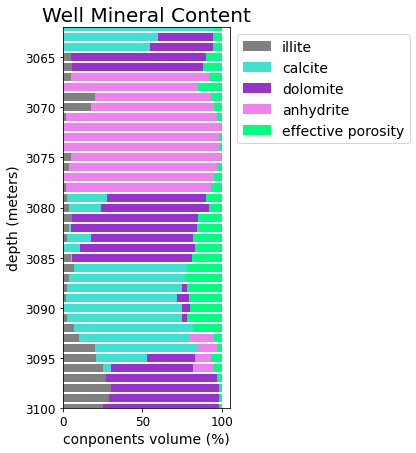

In [333]:
# нарисуем график

cal = np.flip(np.array(cal_prop))
dol = np.flip(np.array(dol_prop))
anh = np.flip(np.array(anh_prop))
ill = np.flip(np.array(ill_prop))
por = np.flip(np.array(por_prop))

turquoise = '#40E0D0'
dark_violet = '#9932CC'
violet = '#EE82EE'
spring_green = '#00FF7F'

plt.figure(figsize = (3, 7))
plt.title('Well Mineral Content', fontsize = 20)

plt.barh(depth, ill, color = 'grey')
plt.barh(depth, cal, color = turquoise, left = ill)
plt.barh(depth, dol, color = dark_violet, left = cal + ill)
plt.barh(depth, anh, color = violet, left = dol + cal + ill)
plt.barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
plt.xlabel('conponents volume (%)', fontsize = 14)
plt.ylabel('depth (meters)', fontsize = 14)

plt.ylim(max(depth), min(depth))

plt.legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'effective porosity'], fontsize = 14,
          bbox_to_anchor=(1, 1))

plt.show()

In [334]:
# упругие модули
calcite = [70.8, 30.3]
dolomite = [80.2, 48.8]
anhydrite = [59.1, 31.4]
illite = [25.3, 16.3]

gas = [0.041, 0]
water = [2.496, 0]


# плотности
rho_components = [2.71, 2.87, 2.97, 2.52]

# Решение

## Прямая задача 

In [335]:
def do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, get_moduli_by_DEM,
                       get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity, props, porosity,
                       calcite = [70.8, 30.3], dolomite = [80.2, 48.8], anhydrite = [59.1, 31.4], illite = [25.3, 16.3],
                       water = [2.496, 0], gas = [0.041, 0], rho_components = [2.71, 2.87, 2.97, 2.52]):

    cal_prop, dol_prop, anh_prop, ill_prop = props[0], props[1], props[2], props[3]
    #print('этапы моделирования:')
    
    cal_dol = [0, 0]
    cal_dol_anh = [0, 0]
    cal_dol_anh_ill = [0, 0]
    
    # кальцит и доломит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol[0] = 0
        cal_dol[1] = 0
    elif cal_prop == 0:
        cal_dol[0] = dolomite[0]
        cal_dol[1] = dolomite[1]
    elif dol_prop == 0:
        cal_dol[0] = calcite[0]
        cal_dol[1] = calcite[1]
    else:
        proportion = round(get_proportion_for_HS(cal_prop, dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, calcite, dolomite, proportion)
        cal_dol[0] = moduli[0]
        cal_dol[1] = moduli[1]
        #print('1. кальцит и доломит по Хашину-Штрикману:', cal_dol)
    
    
    # кальцит, доломит и ангидрит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol_anh[0] = anhydrite[0]
        cal_dol_anh[1] = anhydrite[1]
    elif anh_prop == 0:
        cal_dol_anh[0] = cal_dol[0]
        cal_dol_anh[1] = cal_dol[1]
    else:
        proportion = round(get_proportion_for_HS(anh_prop, cal_prop + dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, anhydrite, cal_dol, proportion)
        cal_dol_anh[0] = moduli[0]
        cal_dol_anh[1] = moduli[1]
        #print('2. (кальцит+доломит) и ангидрит по Хашину-Штрикману:', cal_dol_anh)

        
    # кальцит, доломит, ангидрит + иллит по SCA
    if ill_prop == 0:
        cal_dol_anh_ill[0] = cal_dol_anh[0]
        cal_dol_anh_ill[1] = cal_dol_anh[1]
    else:
        proportion = round(get_proportion_for_HS(ill_prop, cal_prop + dol_prop + anh_prop))
        moduli = get_moduli_by_SCA(get_all_values_by_SCA, [illite[0], illite[1], 0.001],
                                        [cal_dol_anh[0], cal_dol_anh[1], 1], proportion)
        cal_dol_anh_ill[0] = moduli[0]
        cal_dol_anh_ill[1] = moduli[1]
        #print('3. (кальцит+доломит+ангидрит) и иллит по SCA:', cal_dol_anh_ill)

        
    # круглые поры в твердую матрицу по DEM
    matrix_pores = get_moduli_by_DEM(get_all_values_by_DEM, cal_dol_anh_ill, porosity)
    #print('4. круглые поры в твердую матрицу по DEM:', matrix_pores)
    
    # упругие модули флюида по Вуду
    fluid = get_fluid_modulus_by_wood(gas, water, 50)
    #print('5. упругие модули флюида:', fluid)

    # насытим поры флюидом
    saturated = get_saturated_by_gassman(matrix_pores, cal_dol_anh_ill, fluid, porosity)
    #print('6. готовая порода после насыщения пор флюидом:', saturated)
    #print()
    
    # рассчитаем скорости Vp и Vs
    rho_matrix = 0
    for i in range(len(rho_components)):
        rho_matrix += rho_components[i] * props[i] / 100

    rho_fluid = 1 * porosity / 100
    rho = rho_fluid + rho_matrix * (100 - porosity) / 100

    vp, vs = get_velocity(rho, saturated)


    return vp, vs

In [336]:
def get_velocities_in_well(do_forward_problem, cal_prop, dol_prop, anh_prop, ill_prop, por_prop):
    
    well_vp = []
    well_vs = []
    
    for i in range(len(cal_prop)):
        props = [cal_prop[i], dol_prop[i], anh_prop[i], ill_prop[i]]
        porosity = por_prop[i]
        
        vp_sample, vs_sample = do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, 
                                                  get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, 
                                                  get_velocity, props, porosity)
        well_vp.append(vp_sample)
        well_vs.append(vs_sample)
    
    return well_vp, well_vs                                              

In [350]:
all_vp, all_vs = get_velocities_in_well(do_forward_problem, cal_prop, dol_prop, anh_prop, ill_prop, por_prop)

print(all_vp)
print()
print(all_vs)

well_vp = np.flip(np.array(all_vp))
well_vs = np.flip(np.array(all_vs))

[6.274043230786054, 6.504261673453565, 6.540675777721003, 6.676878553169573, 6.597519506994734, 5.5977903573508865, 5.534903226298134, 5.312168840539104, 5.396134736295129, 5.74103300260048, 5.793869561246025, 5.797955573068971, 5.797955573068971, 5.714035148680771, 5.7017214232961635, 5.726982097329433, 5.67227446917456, 6.572075388459291, 6.623575269624648, 6.531992215449216, 6.577104053162119, 6.419170145302844, 6.619994319520096, 6.464866594453619, 5.560774311213939, 5.619212397553356, 5.704839236896742, 5.798928221792253, 5.858962371856694, 5.704839236896742, 5.680845187257207, 5.888016762729903, 5.705603409164872, 5.787054400772071, 5.853342641954445, 6.044996285746547, 5.9680112163389, 5.997936876998311, 6.120233324087969]

[3.3186190972625003, 3.5724956568734836, 3.6094824005896795, 3.906647454662694, 3.8666116136326485, 3.1666055369075012, 3.1502377595338054, 3.0327086290466023, 3.068588286975478, 3.219849735977796, 3.2381666462052343, 3.2423147130634904, 3.2423147130634904, 3

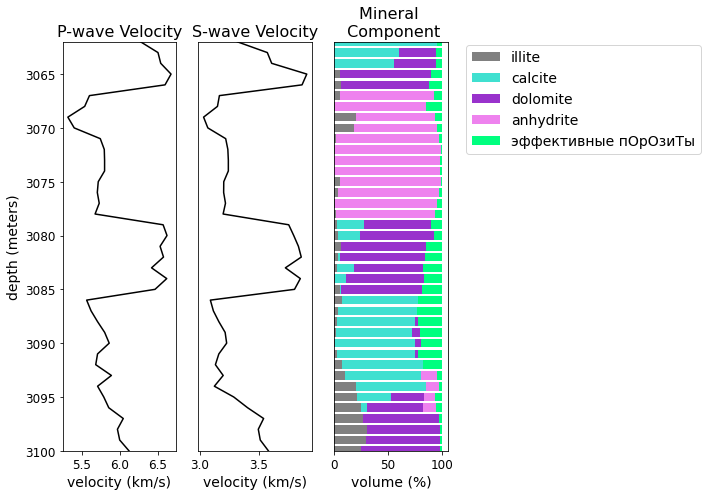

In [353]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))

axes[2].barh(depth, ill, color = 'grey')
axes[2].barh(depth, cal, color = turquoise, left = ill)
axes[2].barh(depth, dol, color = dark_violet, left = cal + ill)
axes[2].barh(depth, anh, color = violet, left = dol + cal + ill)
axes[2].barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
axes[2].set_ylim(bottom = max(depth), top = min(depth))
axes[2].legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'эффективные пОрОзиТы'], fontsize = 14, 
               bbox_to_anchor=(1.1, 1.01))
axes[2].yaxis.set_visible(False)
axes[2].set_title('Mineral \n Component', fontsize = 16)
axes[2].set_xlabel('volume (%)', fontsize = 14)

axes[0].plot(well_vp, depth, c = 'k')
axes[0].set_ylim(bottom = max(depth), top = min(depth))
axes[0].set_title('P-wave Velocity', fontsize = 16)
axes[0].set_xlabel('velocity (km/s)', fontsize = 14)
axes[0].set_ylabel('depth (meters)', fontsize = 14)

axes[1].plot(well_vs, depth, c = 'k')
axes[1].set_ylim(bottom = max(depth), top = min(depth))
axes[1].yaxis.set_visible(False)
axes[1].set_title('S-wave Velocity', fontsize = 16)
axes[1].set_xlabel('velocity (km/s)', fontsize = 14)

fig.tight_layout()

## Обратная задача 

In [354]:
def do_forward_problem_matrix(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, get_moduli_by_DEM,
                       get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity, props, porosity,
                       calcite = [70.8, 30.3], dolomite = [80.2, 48.8], anhydrite = [59.1, 31.4], illite = [25.3, 16.3],
                       water = [2.496, 0], gas = [0.041, 0], rho_components = [2.71, 2.87, 2.97, 2.52]):

    cal_prop, dol_prop, anh_prop, ill_prop = props[0], props[1], props[2], props[3]
    #print('этапы моделирования:')
    
    cal_dol = [0, 0]
    cal_dol_anh = [0, 0]
    cal_dol_anh_ill = [0, 0]
    
    # кальцит и доломит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol[0] = 0
        cal_dol[1] = 0
    elif cal_prop == 0:
        cal_dol[0] = dolomite[0]
        cal_dol[1] = dolomite[1]
    elif dol_prop == 0:
        cal_dol[0] = calcite[0]
        cal_dol[1] = calcite[1]
    else:
        proportion = round(get_proportion_for_HS(cal_prop, dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, calcite, dolomite, proportion)
        cal_dol[0] = moduli[0]
        cal_dol[1] = moduli[1]
        #print('1. кальцит и доломит по Хашину-Штрикману:', cal_dol)
    
    
    # кальцит, доломит и ангидрит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol_anh[0] = anhydrite[0]
        cal_dol_anh[1] = anhydrite[1]
    elif anh_prop == 0:
        cal_dol_anh[0] = cal_dol[0]
        cal_dol_anh[1] = cal_dol[1]
    else:
        proportion = round(get_proportion_for_HS(anh_prop, cal_prop + dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, anhydrite, cal_dol, proportion)
        cal_dol_anh[0] = moduli[0]
        cal_dol_anh[1] = moduli[1]
        #print('2. (кальцит+доломит) и ангидрит по Хашину-Штрикману:', cal_dol_anh)

        
    # кальцит, доломит, ангидрит + иллит по SCA
    if ill_prop == 0:
        cal_dol_anh_ill[0] = cal_dol_anh[0]
        cal_dol_anh_ill[1] = cal_dol_anh[1]
    else:
        proportion = round(get_proportion_for_HS(ill_prop, cal_prop + dol_prop + anh_prop))
        moduli = get_moduli_by_SCA(get_all_values_by_SCA, [illite[0], illite[1], 0.001],
                                        [cal_dol_anh[0], cal_dol_anh[1], 1], proportion)
        cal_dol_anh_ill[0] = moduli[0]
        cal_dol_anh_ill[1] = moduli[1]
        #print('3. (кальцит+доломит+ангидрит) и иллит по SCA:', cal_dol_anh_ill)

        
    # упругие модули флюида по Вуду
    fluid = get_fluid_modulus_by_wood(gas, water, 50)

    rho_matrix = 0
    for i in range(len(rho_components)):
        rho_matrix += rho_components[i] * props[i] / 100


    return cal_dol_anh_ill, fluid, rho_matrix



def do_forward_problem_pores_fast(get_moduli_by_DEM, get_saturated_by_gassman, cal_dol_anh_ill, fluid, rho_matrix, porosity):
    # круглые поры в твердую матрицу по DEM
    matrix_pores = get_moduli_by_DEM(get_all_values_by_DEM, cal_dol_anh_ill, porosity)

    # насытим поры флюидом
    saturated = get_saturated_by_gassman(matrix_pores, cal_dol_anh_ill, fluid, porosity)

    # рассчитаем скорости Vp и Vs
    rho_fluid = 1
    rho = rho_matrix * (1 - porosity/100) + rho_fluid * porosity/100
    k, g = saturated[0], saturated[1]

    vp = math.sqrt((k + g * 4 / 3) / rho)
    vs = math.sqrt(g / rho)

    return vp, vs

## Монте-Карло 

In [370]:
def check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error):
    error = math.sqrt((vp_true - vp_sample)**2 + (vs_true - vs_sample)**2)
    if error < allowable_error:
        return True
    else:
        return False
    

    
def do_monte_carlo(do_forward_problem_pores_fast, get_moduli_by_DEM, get_saturated_by_gassman, 
                   check_how_close, cal_dol_anh_ill, fluid, rho_matrix, vp_true, vs_true, N = 1000, allowable_error = 0.1):
    
    por_np = np.around((np.random.random(N)) * 30, decimals = 1)
    por = por_np.tolist()
    
    vs = []
    vp = []
    good_por = []

    for i in range(len(por)):
        porosity = por[i]
        vp_sample, vs_sample = do_forward_problem_pores_fast(get_moduli_by_DEM, get_saturated_by_gassman, 
                                                               cal_dol_anh_ill, fluid, rho_matrix, porosity)
    
        check = check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error)

        if check == True:
            vp.append(vp_sample)
            vs.append(vs_sample)
            good_por.append(por[i])

    avg_por = sum(good_por) / len(good_por)
    
    return avg_por

In [371]:
def do_inverse_problem(do_monte_carlo, cal_prop, dol_prop, anh_prop, ill_prop, well_vp, well_vs):
    
    all_por = []
    
    for i in range(len(well_vp)):
        
        props = [cal_prop[i], dol_prop[i], anh_prop[i], ill_prop[i]]
        porosity = por_prop[i]
        
        vp_true = well_vp[i]
        vs_true = well_vs[i]
        
        cal_dol_anh_ill, fluid, rho_matrix = do_forward_problem_matrix(get_proportion_for_HS, get_moduli_by_HS, 
                        get_moduli_by_SCA, get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, 
                        get_velocity, props, porosity, calcite = [70.8, 30.3], dolomite = [80.2, 48.8], 
                        anhydrite = [59.1, 31.4], illite = [25.3, 16.3], water = [2.496, 0], gas = [0.041, 0], 
                        rho_components = [2.71, 2.87, 2.97, 2.52])
        
        avg_por = do_monte_carlo(do_forward_problem_pores_fast, get_moduli_by_DEM, get_saturated_by_gassman, 
                                 check_how_close, cal_dol_anh_ill, fluid, rho_matrix, vp_true, vs_true)
        
        all_por.append(avg_por)
        
        print(avg_por)
    
    return(all_por)

In [372]:
all_por = do_inverse_problem(do_monte_carlo, cal_prop, dol_prop, anh_prop, ill_prop, well_vp, well_vs)

ZeroDivisionError: division by zero